# Test numerical derivative method

## Defining function

In [1]:
# Liberary
import numpy as np
from scipy.interpolate import CubicSpline
import datetime
import threading
import multiprocessing as mp
from matplotlib import pyplot as plt
from time import time
from scipy.stats import norm
%matplotlib inline
plt.style.use('bmh')

In [2]:
#
import sympy
z = sympy.symbols('z')
K0 = 1e-6
K1 = 6e-3# m / s
Aalpha = 0.5
w=0

sym_Difty =  K0 + K1 * z * sympy.exp(-Aalpha * z)
sym_dDdz = sympy.diff(sym_Difty, z, 1)

Difty  =  sympy.utilities.lambdify(z, sym_Difty,np)
dDdz   =  sympy.utilities.lambdify(z,          sym_dDdz,np)
del z

def K(z):
    return np.where(z<0, Difty(-z), Difty(z))

def dKdz(z):
    return np.where(z<0, -dDdz(-z), dDdz(z))

In [3]:
# SDE schemes
# Euler-Maruyama

def step_e(z, H, dt, N_sample):

    dW = np.random.normal(0, np.sqrt(dt), N_sample)

    a = dKdz(z)
    b = np.sqrt(2 * K(z))

    temp = z + a * dt + b * dW

    return temp

def step_e_finiteDiff(z, H, dt, N_sample):

    dW = np.random.normal(0, np.sqrt(dt), N_sample)
    
    dz = 1.2e-3
    
    a = (K(z+dz)-K(z-dz))/(2*dz)
    b = np.sqrt(2 * K(z))

    temp = z + a * dt + b * dW

    return temp

In [4]:
# Parallel functions

def oneStep2(Z ,scheme, H, dt):
    
    Z_Origin = Z.copy()
    Z = scheme(Z, H, dt, Z.size)
    
    maskCross = ((H < Z) | (0 > Z)) 
    Crossing = Z_Origin[maskCross]
    
    Z = np.where(Z < 0, -Z, Z)
    Z = np.where(Z > H, 2*H - Z, Z)
    
    Landing = Z[maskCross]
    
    return Z, Crossing, Landing

def parallel2(Tmax, dt, H, Testdepth, Np, Nbins, quene, queneCross, queneLand,
             scheme):

    np.random.seed()
    Ntime = int(Tmax / dt)

    hist_ = np.zeros((Nbins - 1, ), 'uint64')
    hist_Cross = np.zeros((Nbins - 1, ), 'uint64')
    hist_Land = np.zeros((Nbins - 1, ), 'uint64')

    z = np.linspace(0, H, int(Np))
    #z = np.random.uniform(0, H, int(Np))

    temp0, _ = np.histogram(z, bins=np.linspace(0, Testdepth, Nbins))
    hist_ = hist_ + temp0
    
    for i in range(Ntime):

        z, Cross, Land = oneStep2(z, scheme, H, dt)

        #Adding the histogram
        ###
        temp0, _ = np.histogram(z, bins=np.linspace(0, Testdepth, Nbins))
        hist_ = hist_ + temp0

        temp2, _ = np.histogram(Cross, bins=np.linspace(0, Testdepth, Nbins))
        hist_Cross = hist_Cross + temp2

        temp3, _ = np.histogram(Land, bins=np.linspace(0, Testdepth, Nbins))
        hist_Land = hist_Land + temp3
        
        try:
            if (i % int(Ntime / 100) == 0):
                print("\r %6.2f" % (i * 100 / Ntime + 1),
                      "%",
                      end="\r",
                      flush=True)
        except ZeroDivisionError as err:
            None
            
    quene.put(hist_)
    queneCross.put(hist_Cross)
    queneLand.put(hist_Land)

    return None

def RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, scheme):
    print("Total number of process: ", NumberOfThread)
    SubNp = np.full((NumberOfThread, ), int(Np / NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np % NumberOfThread)
    
    Ntime = int(Tmax / dt)  #Number of time interval

    if (__name__ == '__main__'):

        threads = []
        quene = mp.Queue()
        queneCross = mp.Queue()
        queneLand = mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target=parallel2,
                                args=(Tmax, dt, H, Testdepth, SubNp[i], Nbins,
                                      quene, queneCross, queneLand, scheme))

            threads.append(thread)
            thread.start()  #starting calculation.

        for thread in threads:
            thread.join()  #waiting these processes finish.

    hist_ = np.zeros((Nbins - 1, ), 'float64')
    hist_Cross = np.zeros((Nbins - 1, ), 'float64')
    hist_Land = np.zeros((Nbins - 1, ), 'float64')

    for i in range(NumberOfThread):
        hist_ += quene.get()
        hist_Cross += queneCross.get()
        hist_Land += queneLand.get()
        
    bins = np.linspace(0, Testdepth, Nbins)
    dz = bins[1] - bins[0]
    hist_ = (hist_*H) / (Np * dz * (Ntime+1))

    lists = []
    lists.append(hist_)

    lists_2 = []
    lists_2.append(hist_Cross)

    lists_3 = []
    lists_3.append(hist_Land)

    return hist_, hist_Cross, hist_Land

In [5]:
# Parallel functions

def oneStep(Z, scheme, H, dt):

    Z = scheme(Z, H, dt, Z.size)

    Z = np.where(Z < 0, -Z, Z)
    Z = np.where(Z > H, 2 * H - Z, Z)

    return Z

def parallel(Tmax, dt, H, Testdepth, Np, Nbins, quene, scheme):

    np.random.seed()
    Ntime = int(Tmax / dt)

    hist_ = np.zeros((Nbins - 1, ), 'uint64')

    z = np.linspace(0, H, int(Np))
    #z = np.random.uniform(0, H, int(Np))

    temp0, _ = np.histogram(z, bins=np.linspace(0, Testdepth, Nbins))
    hist_ = hist_ + temp0

    for i in range(Ntime):

        z = oneStep(z, scheme, H, dt)

        #Adding the histogram
        ###
        temp0, _ = np.histogram(z, bins=np.linspace(0, Testdepth, Nbins))
        hist_ = hist_ + temp0

        try:
            if (i % int(Ntime / 100) == 0):
                print("\r %6.2f" % (i * 100 / Ntime + 1),
                      "%",
                      end="\r",
                      flush=True)
        except ZeroDivisionError as err:
            None

    quene.put(hist_)

    return None

def RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, scheme):
    print("Total number of process: ", NumberOfThread)
    SubNp = np.full((NumberOfThread, ), int(Np / NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np % NumberOfThread)

    Ntime = int(Tmax / dt)  #Number of time interval

    if (__name__ == '__main__'):

        threads = []
        quene = mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target=parallel,
                                args=(Tmax, dt, H, Testdepth, SubNp[i], Nbins,
                                      quene, scheme))

            threads.append(thread)
            thread.start()  #starting calculation.

        for thread in threads:
            thread.join()  #waiting these processes finish.

    hist_ = np.zeros((Nbins - 1, ), 'float64')

    for i in range(NumberOfThread):
        hist_ += quene.get()

    bins = np.linspace(0, Testdepth, Nbins)
    dz = bins[1] - bins[0]
    hist_ = (hist_ * H) / (Np * dz * (Ntime + 1))

    return hist_

## Testing E1

In [6]:
#

Np = 20000
Nbins = 1000
dt = 0.5
Tmax = 24 * 3600
H = 2
Testdepth = 0.05
NumberOfThread = 4


EM = RunSimulation(NumberOfThread, Tmax, dt, H,
                                            Testdepth, Np, Nbins, step_e)


EM_finDif = RunSimulation(NumberOfThread, Tmax, dt, H,
                                           Testdepth, Np, Nbins, step_e_finiteDiff)

bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1] - bins[0]) / 2


Total number of process:  4
Total number of process:  4


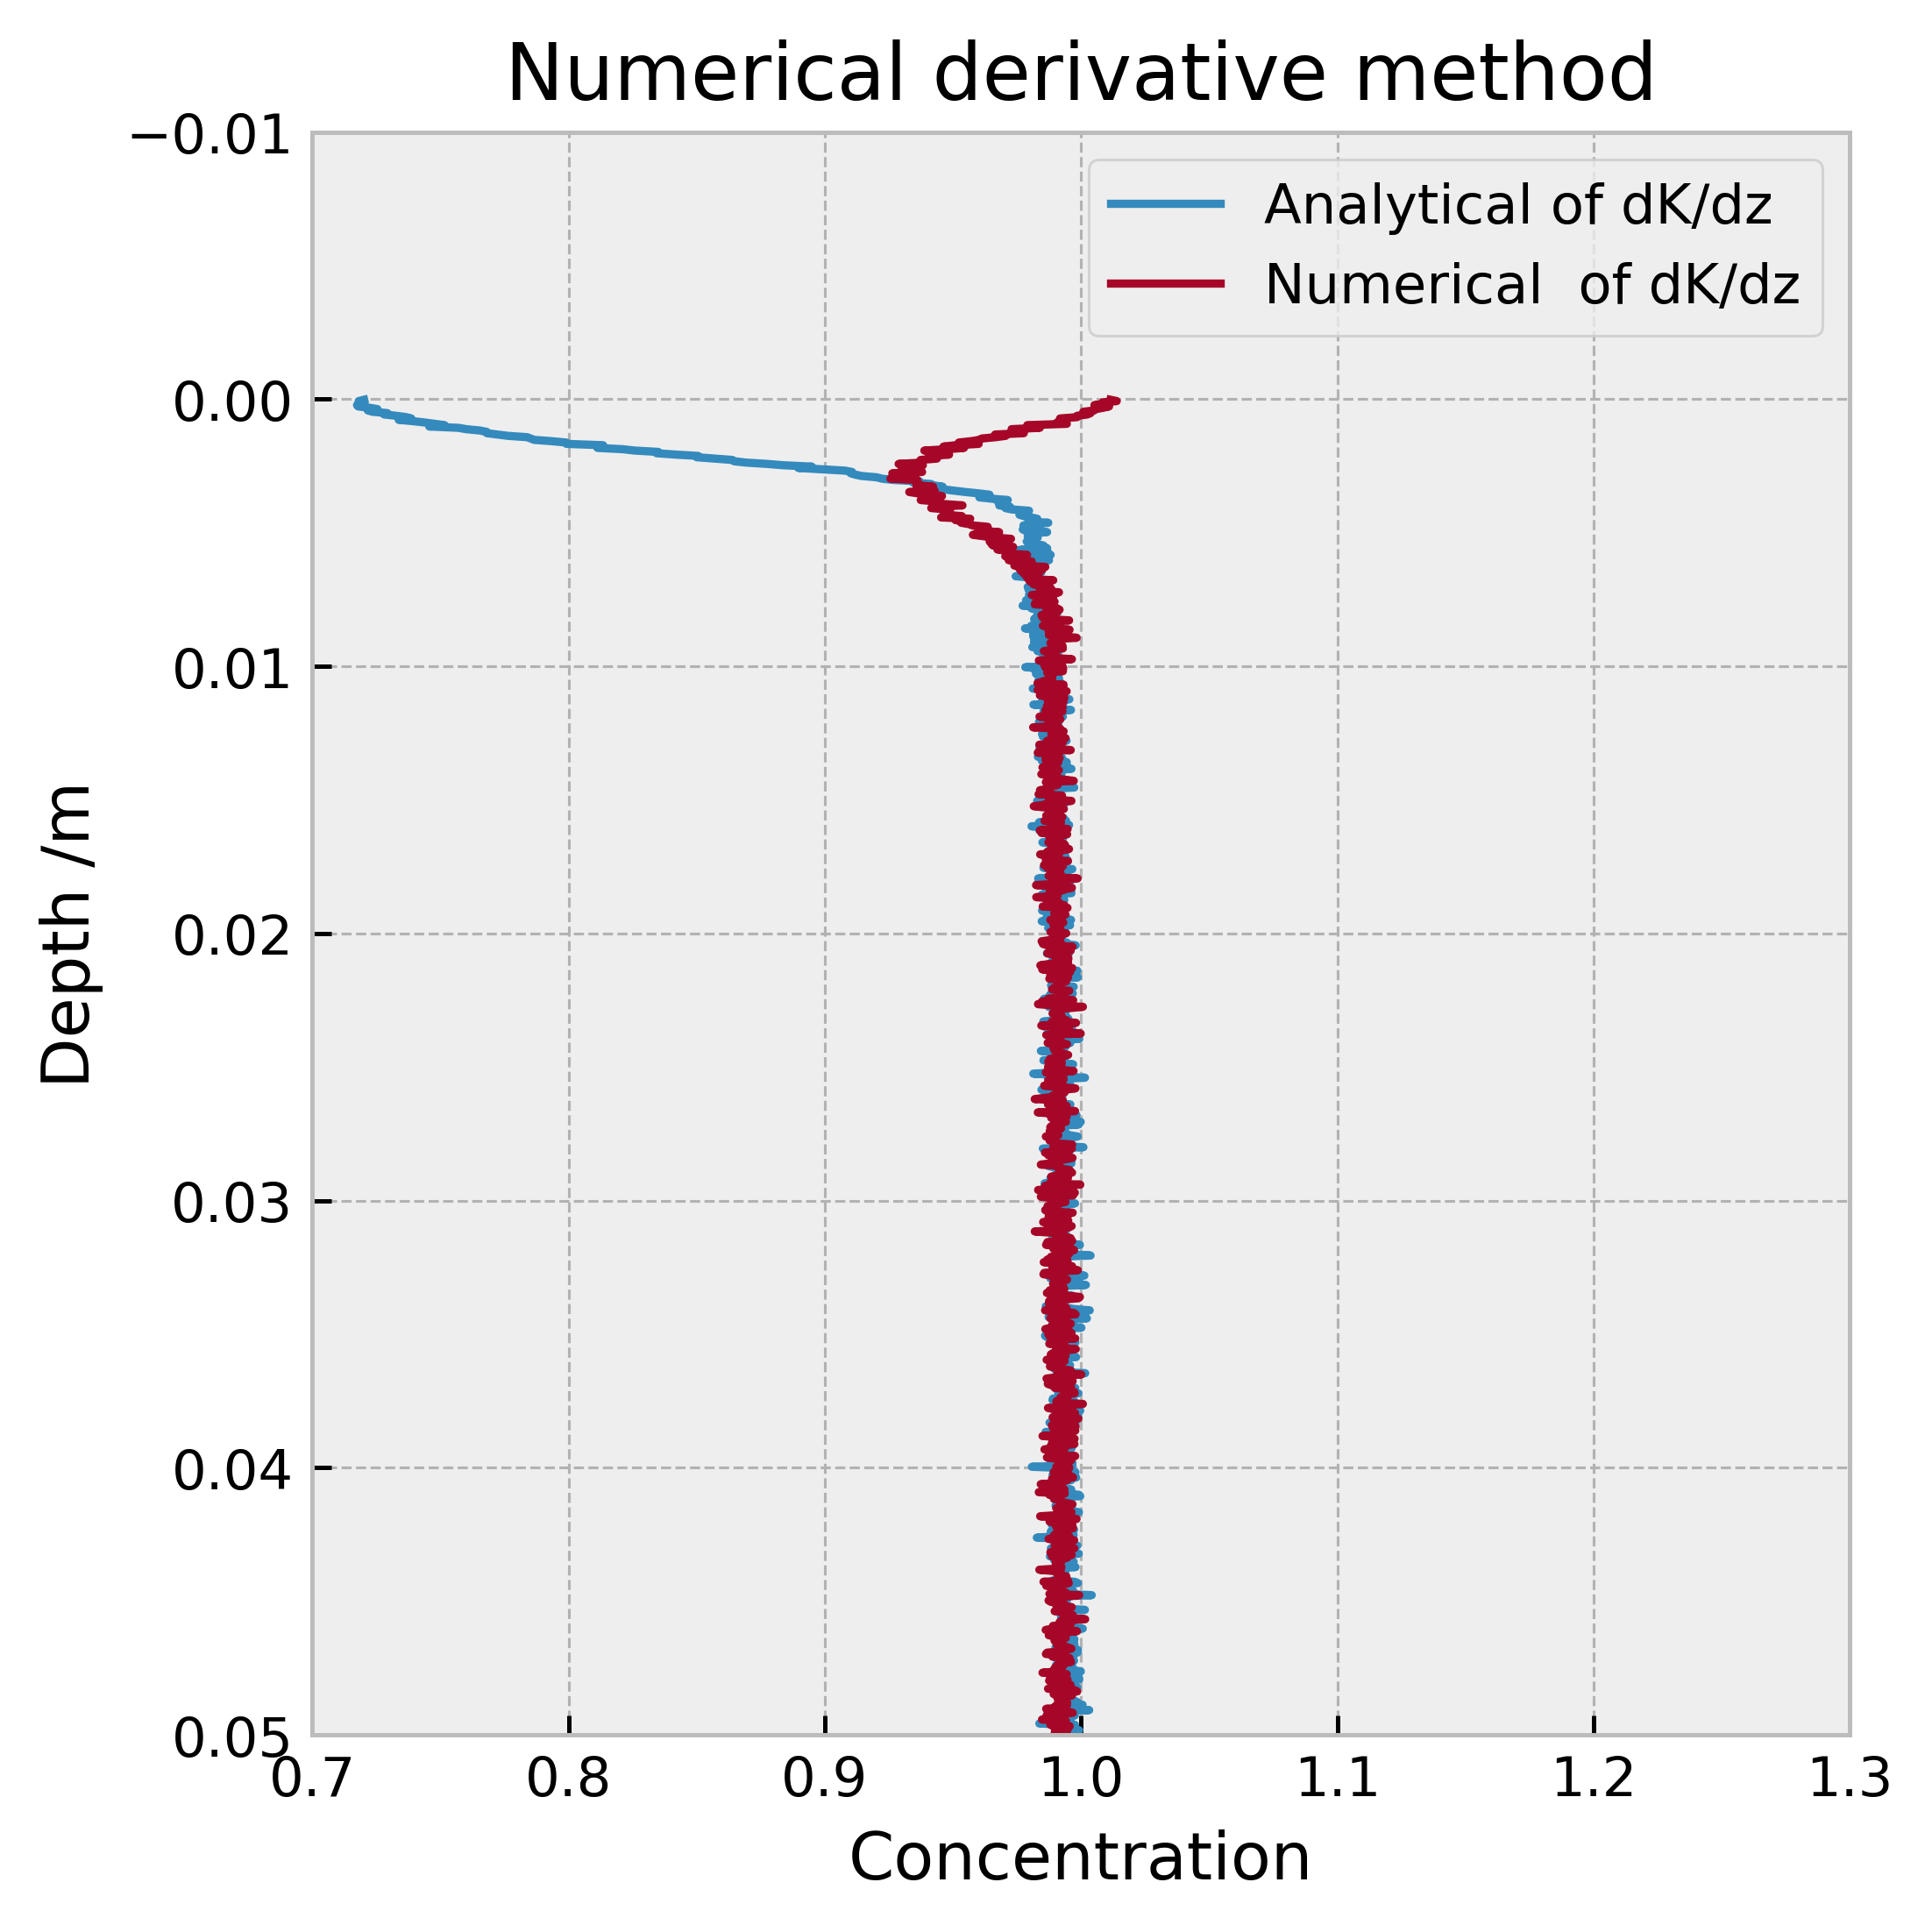

In [7]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 5), sharey=True, dpi = 450)

ax.plot(EM, midpoints, linewidth=1.5, label= "Analytical of dK/dz")
ax.plot(EM_finDif, midpoints, linewidth=1.5, label= "Numerical  of dK/dz")
ax.set_xlabel('Concentration')
ax.set_ylabel('Depth /m')
ax.set_title('Numerical derivative method')
ax.set_xlim(0.7, 1.3)
ax.set_ylim(-0.01, 0.05)
ax.legend()
ax.invert_yaxis()
plt.tight_layout()

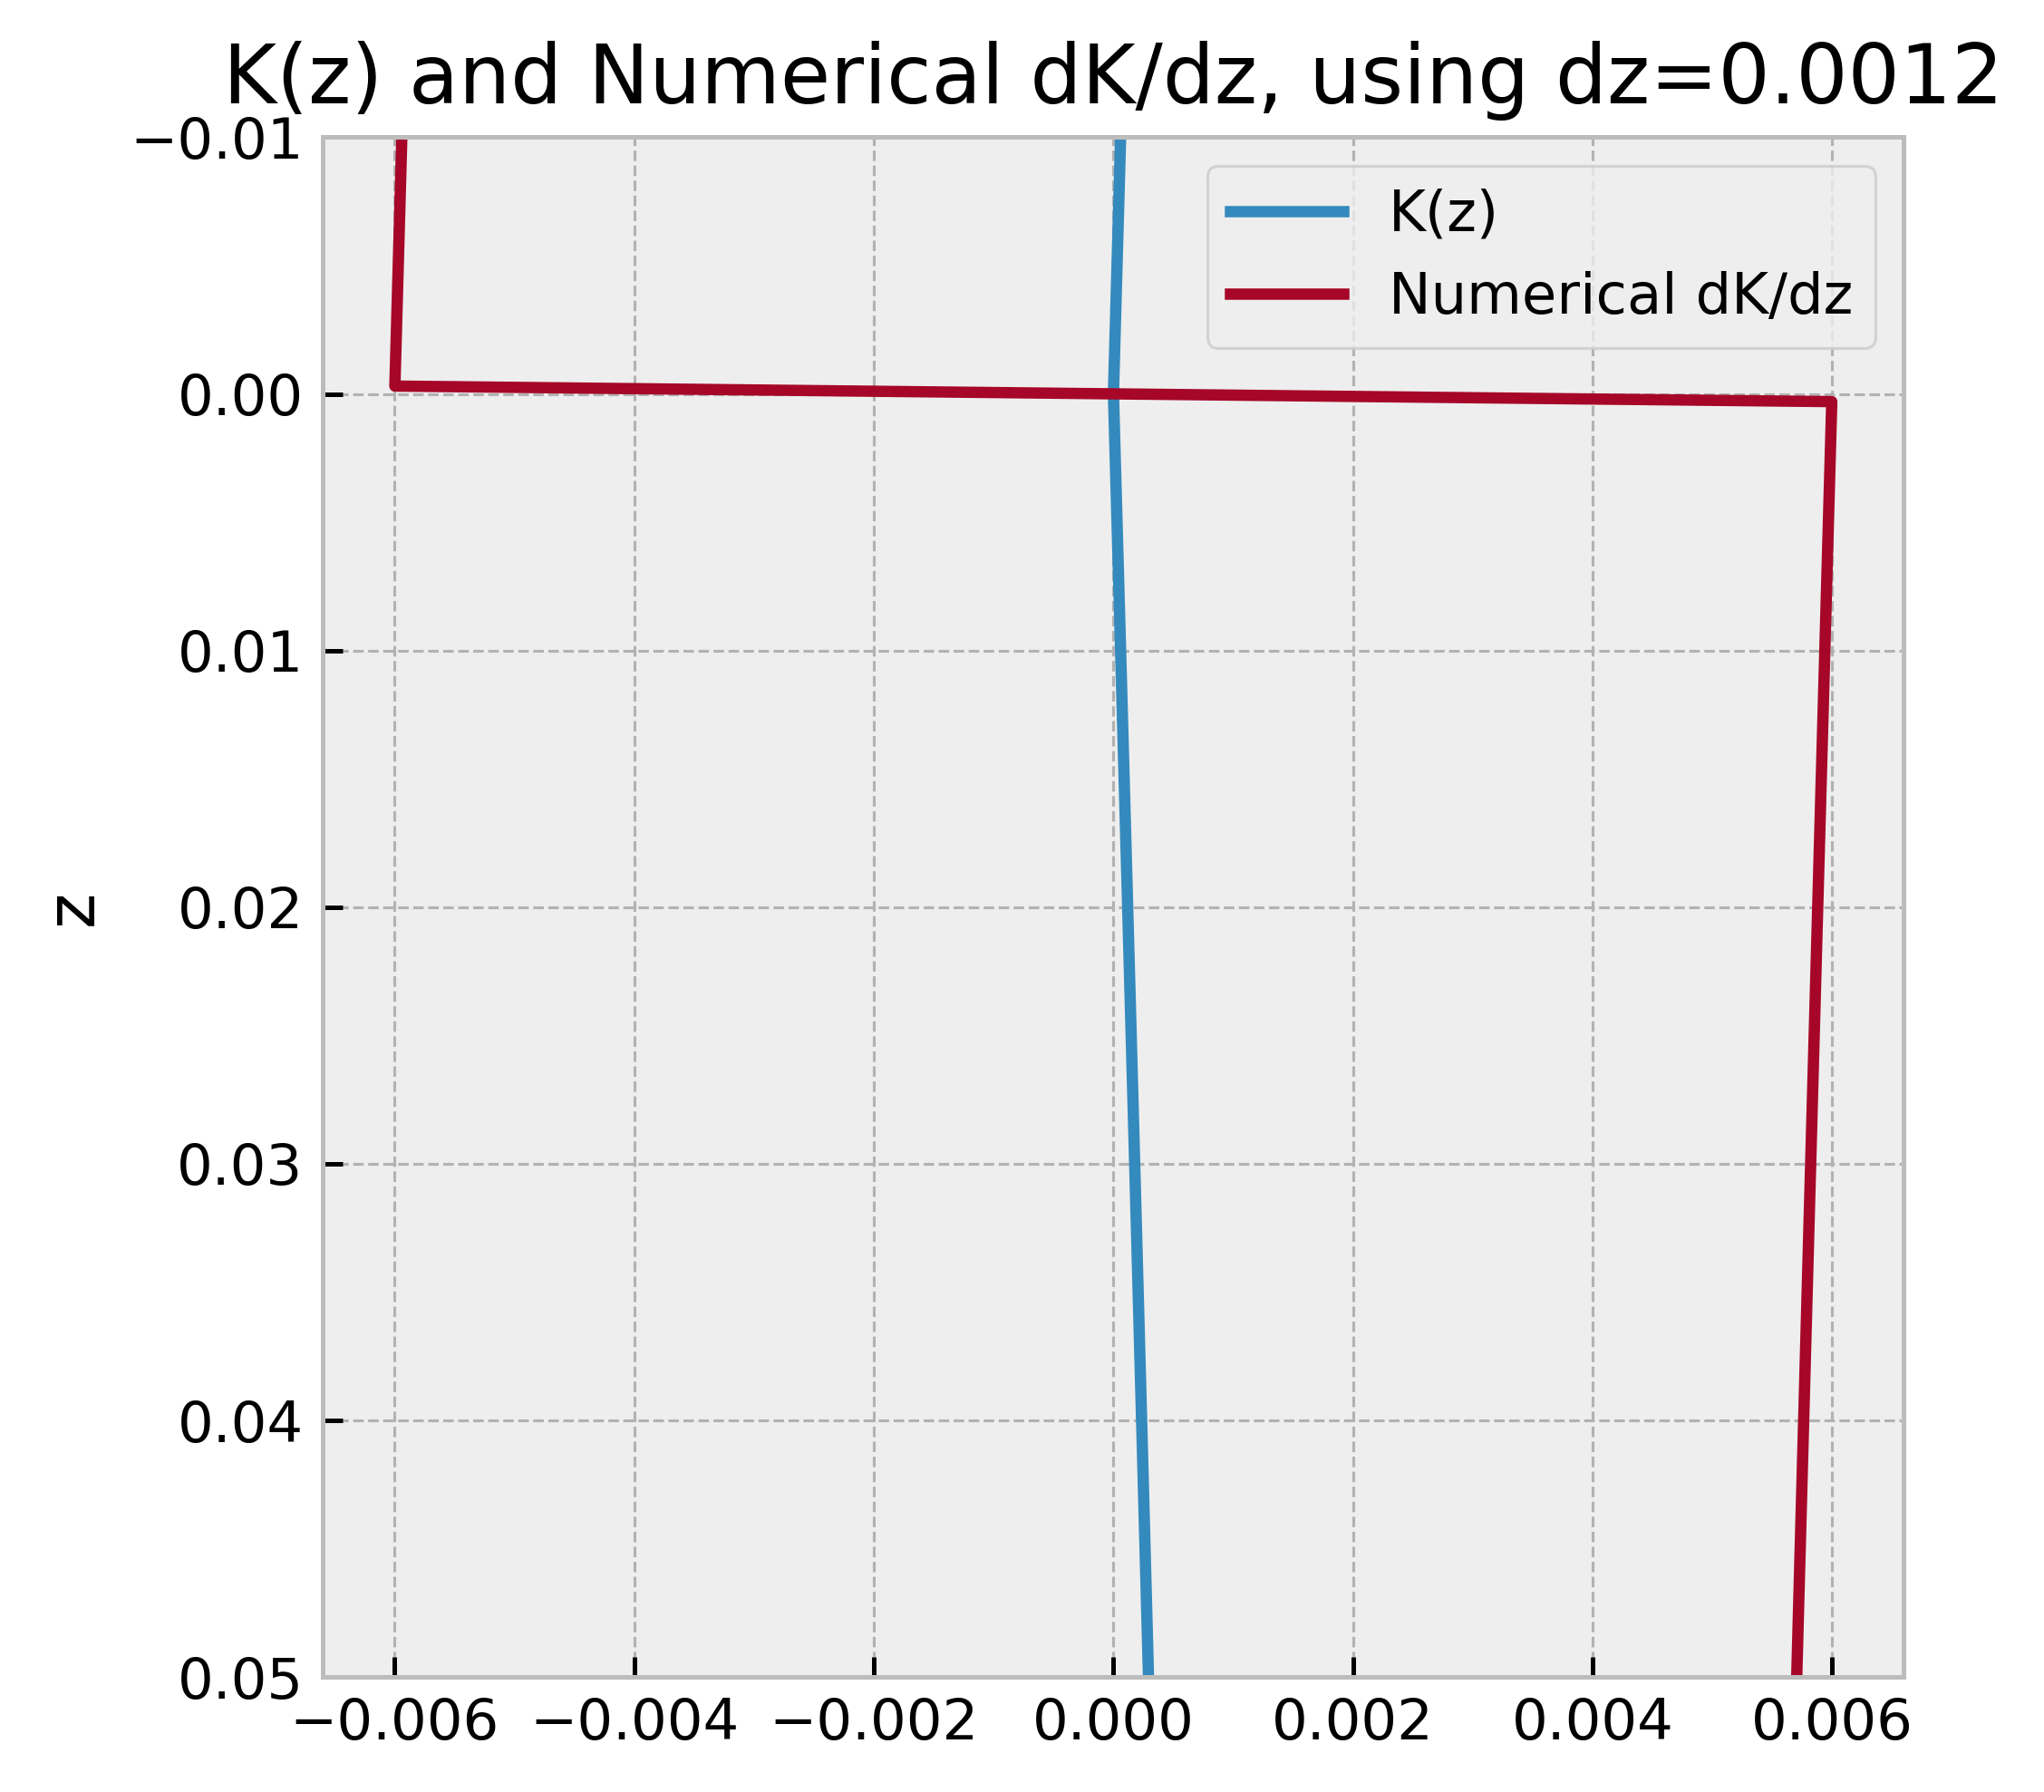

In [8]:
z = np.linspace(-0.01, 0.05, 100)

plt.figure(figsize=(5, 5), dpi = 450)
plt.plot(K(z), z, label ="K(z)")
plt.plot(dKdz(z), z, label ="Numerical dK/dz")
plt.ylabel("z")
plt.ylim(-0.01, 0.05)
plt.gca().invert_yaxis()
plt.title("K(z) and Numerical dK/dz, using dz=0.0012")
plt.legend()